In [1]:
%cd ..

/home/jupyter-tim/ba-tim


In [35]:
from drlqap.taskgenerators import generators, RandomWeightsTaskGenerator, RandomMatricesTaskGenerator, LinearTaskGenerator
from collections import defaultdict

In [3]:
# Generate new problems
sizes = [4,6,8,12,16,24,32,48,64,96,128]
count = 20
problems = {
    i: [RandomWeightsTaskGenerator(i).sample() for _ in range(count)] for i in sizes
}

In [4]:
# Clear results
results = {}

In [36]:
import scipy.optimize
from drlqap.simplesolver import solve_qap_backtracking, solve_qap_maxgreedy, solve_qap_faq, solve_random, solve_partial_random, solve_best_of_k
from drlqap.gurobi import solve_qap_gurobi
import numpy as np
from drlqap.qap import QAP
from drlqap.evaltools import load_checkpoints
from pathlib import Path
import random
import matplotlib
import matplotlib.pyplot as plt
import time
import importlib
import torch
import math

In [6]:
def evaluate(solver, problem, samples):
    if type(problem) == str:
        generator = generators[problem]
    else:
        generator = problem
    qaps = [generator.sample() for i in range(samples)]
    return evaluate_set(solver, qaps)
    
def evaluate_set(solver, problems):
    with torch.no_grad():
        start = time.perf_counter()
        values = []
        correct = 0
        for qap in problems:
            v_solver, assignment = solver(qap)
            v = qap.compute_value(assignment)
            if not np.isclose(v, v_solver):
                print (f"solver outputs incorrect value (got {v_solver}, actual {v})")
            values.append(v)
        end = time.perf_counter()
        mean = np.mean(values)
        variance = np.var(values)
        return mean, variance, (end - start) / len(problems)

In [7]:
def evaluate_full_and_store(solver_name, force=False, max_size=math.inf):
    if solver_name not in results or force:
        solver = solvers[solver_name]
        means = []
        variances = []
        times = []
        for n in sizes:
            if n < max_size:
                m, v, t = evaluate_set(solver, problems[n])
                means.append(m)
                variances.append(v)
                times.append(t)
                print(f"{solver_name} on n={n}: mean={m:.3f}, var={v:.3f}, t={t:.3f}")
                results[solver_name] = {
                    "means": np.array(means),
                    "vars": np.array(variances),
                    "times": np.array(times)
                }

In [39]:
solvers = {
    'faq': solve_qap_faq,
    'a2c_md': load_checkpoints(Path('runs/a2c_ms100x_mediumrandoms/lr4e-5_s3'))[-1].solve,
    'random': solve_random,
    'max_greedy': solve_qap_maxgreedy,
    'dqn_sm': load_checkpoints(Path('runs/dqn_dense_ms_ec_eps0_smallrandoms/lr5e-4_s1'))[-1].solve,
    'dqn_md': load_checkpoints(Path('runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1'))[-1].solve,
    'rf': load_checkpoints(Path('runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/'))[-1].solve,
    'last7opt': lambda qap: solve_partial_random(qap, 7),
    'last8opt': lambda qap: solve_partial_random(qap, 8),
    'rand1k': lambda qap: solve_best_of_k(qap, 1000, solve_random),
    'rand5k': lambda qap: solve_best_of_k(qap, 5000, solve_random),
    'rand10k': lambda qap: solve_best_of_k(qap, 10000, solve_random),
    'a2c_sm': load_checkpoints(Path('runs/a2c_ms100x_smallrandoms/lr4e-5_s2'))[-1].solve,
    'mcq_sm': load_checkpoints(Path('runs/mcq_eps0_smallrandoms/lr3e-4_s2'))[-1].solve,
    'dqn_md_e': load_checkpoints(Path('runs/dqn_dense_ms_ec_mediumrandoms/lr5e-4_s1'))[-1].solve,
    'dqn_ms': load_checkpoints(Path('runs/dqn_dense_ec_eps0_norm_study/s3_mean_separation/'))[-1].solve,
    'dqn_ms100x': load_checkpoints(Path('runs/dqn_dense_ec_eps0_norm_study/s3_mean_separation_100x/'))[-1].solve,
    'dqn_tmn': load_checkpoints(Path('runs/dqn_dense_ec_eps0_norm_study/s3_transformed_mean/'))[-1].solve,
    'dqn_kmn': load_checkpoints(Path('runs/dqn_dense_ec_eps0_norm_study/s3_keep_mean/'))[-1].solve,
    'dqn_pn': load_checkpoints(Path('runs/dqn_dense_ec_eps0_norm_study/s3_pair_norm/'))[-1].solve,
    'dqn_sm2': load_checkpoints(Path('runs/dqn_dense_ec_eps0_norm_study/s3_None/'))[-1].solve,
    'rf_pn': load_checkpoints(Path('runs/reinforce_norm_study/s3_pair_norm/'))[-1].solve,
    'rf_ms100x': load_checkpoints(Path('runs/reinforce_norm_study/s1_mean_separation_100x/'))[-1].solve,
    
    'a2c_none': load_checkpoints(Path('runs/a2c_ms100x_norm_study/s2_None/'))[-1].solve,
    'a2c_ms': load_checkpoints(Path('runs/a2c_ms100x_norm_study/s2_mean_separation/'))[-1].solve,
    'a2c_ms100x': load_checkpoints(Path('runs/a2c_ms100x_norm_study/s2_mean_separation_100x/'))[-1].solve,
    'a2c_kmn': load_checkpoints(Path('runs/a2c_ms100x_norm_study/s2_keep_mean/'))[-1].solve,
    'a2c_pn': load_checkpoints(Path('runs/a2c_ms100x_norm_study/s2_pair_norm/'))[-1].solve,
    'a2c_none_2': load_checkpoints(Path('runs/a2c_ms100x_norm_study/s3_None/'))[-1].solve,
    'a2c_ms_2': load_checkpoints(Path('runs/a2c_ms100x_norm_study/s3_mean_separation/'))[-1].solve,
    'a2c_ms100x_2': load_checkpoints(Path('runs/a2c_ms100x_norm_study/s3_mean_separation_100x/'))[-1].solve,
    'a2c_kmn_2': load_checkpoints(Path('runs/a2c_ms100x_norm_study/s3_keep_mean/'))[-1].solve,
    'a2c_pn_2': load_checkpoints(Path('runs/a2c_ms100x_norm_study/s3_pair_norm/'))[-1].solve,
    #'gurobi_5s': lambda qap: solve_qap_gurobi(qap, time_limit=5),
}

solvers['rf_top5'] = lambda qap: solve_best_of_k(qap, 5, solvers['rf'])
solvers['rf_top20'] = lambda qap: solve_best_of_k(qap, 20, solvers['rf'])
solvers['a2c_top5'] = lambda qap: solve_best_of_k(qap, 5, solvers['a2c_sm'])
solvers['a2c_top20'] = lambda qap: solve_best_of_k(qap, 20, solvers['a2c_sm'])


runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_0.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_1000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_2000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_3000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_4000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_5000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_6000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_7000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_8000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_9000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_10000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_11000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_12000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_13000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_14000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_15000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_

runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_11000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_12000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_13000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_14000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_15000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_16000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_17000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_18000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_19000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_20000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_21000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_22000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_23000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_24000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_25000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_26000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_27000.pth
runs/mcq_eps0_

runs/reinforce_norm_study/s3_pair_norm/checkpoint_end.pth
runs/reinforce_norm_study/s1_mean_separation_100x/checkpoint_0.pth
runs/reinforce_norm_study/s1_mean_separation_100x/checkpoint_1000.pth
runs/reinforce_norm_study/s1_mean_separation_100x/checkpoint_2000.pth
runs/reinforce_norm_study/s1_mean_separation_100x/checkpoint_3000.pth
runs/reinforce_norm_study/s1_mean_separation_100x/checkpoint_4000.pth
runs/reinforce_norm_study/s1_mean_separation_100x/checkpoint_5000.pth
runs/reinforce_norm_study/s1_mean_separation_100x/checkpoint_6000.pth
runs/reinforce_norm_study/s1_mean_separation_100x/checkpoint_7000.pth
runs/reinforce_norm_study/s1_mean_separation_100x/checkpoint_8000.pth
runs/reinforce_norm_study/s1_mean_separation_100x/checkpoint_9000.pth
runs/reinforce_norm_study/s1_mean_separation_100x/checkpoint_10000.pth
runs/reinforce_norm_study/s1_mean_separation_100x/checkpoint_11000.pth
runs/reinforce_norm_study/s1_mean_separation_100x/checkpoint_12000.pth
runs/reinforce_norm_study/s1_mea

runs/a2c_ms100x_norm_study/s2_pair_norm/checkpoint_14000.pth
runs/a2c_ms100x_norm_study/s2_pair_norm/checkpoint_15000.pth
runs/a2c_ms100x_norm_study/s2_pair_norm/checkpoint_16000.pth
runs/a2c_ms100x_norm_study/s2_pair_norm/checkpoint_17000.pth
runs/a2c_ms100x_norm_study/s2_pair_norm/checkpoint_18000.pth
runs/a2c_ms100x_norm_study/s2_pair_norm/checkpoint_19000.pth
runs/a2c_ms100x_norm_study/s2_pair_norm/checkpoint_end.pth
runs/a2c_ms100x_norm_study/s3_None/checkpoint_0.pth
runs/a2c_ms100x_norm_study/s3_None/checkpoint_1000.pth
runs/a2c_ms100x_norm_study/s3_None/checkpoint_2000.pth
runs/a2c_ms100x_norm_study/s3_None/checkpoint_3000.pth
runs/a2c_ms100x_norm_study/s3_None/checkpoint_4000.pth
runs/a2c_ms100x_norm_study/s3_None/checkpoint_5000.pth
runs/a2c_ms100x_norm_study/s3_None/checkpoint_6000.pth
runs/a2c_ms100x_norm_study/s3_None/checkpoint_7000.pth
runs/a2c_ms100x_norm_study/s3_None/checkpoint_8000.pth
runs/a2c_ms100x_norm_study/s3_None/checkpoint_9000.pth
runs/a2c_ms100x_norm_study/s

In [9]:
evaluate_full_and_store("random")

random on n=4: mean=3.132, var=1.244, t=0.000
random on n=6: mean=7.285, var=2.814, t=0.000
random on n=8: mean=14.317, var=4.762, t=0.000
random on n=12: mean=34.549, var=9.969, t=0.000
random on n=16: mean=59.165, var=23.541, t=0.000
random on n=24: mean=136.582, var=48.578, t=0.000
random on n=32: mean=243.810, var=99.256, t=0.000
random on n=48: mean=571.133, var=240.622, t=0.000
random on n=64: mean=1010.988, var=332.415, t=0.000
random on n=96: mean=2277.611, var=953.150, t=0.001
random on n=128: mean=4058.759, var=1804.496, t=0.001


In [10]:
evaluate_full_and_store("faq")

faq on n=4: mean=2.668, var=1.442, t=0.002
faq on n=6: mean=5.779, var=2.350, t=0.003
faq on n=8: mean=12.019, var=5.298, t=0.003
faq on n=12: mean=28.467, var=10.941, t=0.004
faq on n=16: mean=48.709, var=17.278, t=0.004
faq on n=24: mean=116.313, var=59.134, t=0.006
faq on n=32: mean=207.501, var=101.828, t=0.008
faq on n=48: mean=496.127, var=234.159, t=0.015
faq on n=64: mean=892.285, var=241.847, t=0.031
faq on n=96: mean=2038.580, var=940.925, t=0.093
faq on n=128: mean=3683.656, var=1286.335, t=0.142


In [11]:
evaluate_full_and_store("max_greedy")

max_greedy on n=4: mean=2.542, var=1.236, t=0.002
max_greedy on n=6: mean=6.001, var=2.280, t=0.002
max_greedy on n=8: mean=12.899, var=5.111, t=0.003
max_greedy on n=12: mean=31.250, var=9.240, t=0.004
max_greedy on n=16: mean=54.190, var=13.722, t=0.006
max_greedy on n=24: mean=130.355, var=73.521, t=0.008
max_greedy on n=32: mean=231.554, var=74.843, t=0.011
max_greedy on n=48: mean=550.703, var=218.997, t=0.017
max_greedy on n=64: mean=983.203, var=178.524, t=0.030
max_greedy on n=96: mean=2229.648, var=909.346, t=0.055
max_greedy on n=128: mean=4001.264, var=1497.157, t=0.072


In [12]:
evaluate_full_and_store("dqn_sm")
evaluate_full_and_store("rf")

dqn_sm on n=4: mean=2.626, var=1.133, t=0.012
dqn_sm on n=6: mean=5.824, var=1.837, t=0.018
dqn_sm on n=8: mean=12.570, var=4.780, t=0.026
dqn_sm on n=12: mean=30.549, var=10.570, t=0.041
dqn_sm on n=16: mean=53.419, var=20.462, t=0.058
dqn_sm on n=24: mean=132.813, var=62.861, t=0.095
dqn_sm on n=32: mean=240.572, var=107.163, t=0.141
dqn_sm on n=48: mean=573.962, var=208.871, t=0.248
dqn_sm on n=64: mean=1023.749, var=319.279, t=0.391
dqn_sm on n=96: mean=2306.820, var=709.919, t=0.744
dqn_sm on n=128: mean=4108.253, var=1258.953, t=1.278
rf on n=4: mean=2.712, var=1.518, t=0.013
rf on n=6: mean=5.976, var=1.721, t=0.022
rf on n=8: mean=13.067, var=5.643, t=0.029
rf on n=12: mean=31.252, var=7.908, t=0.047
rf on n=16: mean=54.252, var=11.768, t=0.065
rf on n=24: mean=129.661, var=56.495, t=0.271
rf on n=32: mean=232.200, var=103.278, t=0.404
rf on n=48: mean=552.652, var=230.339, t=0.523
rf on n=64: mean=986.390, var=316.264, t=0.834
rf on n=96: mean=2233.197, var=1086.241, t=1.040
r

In [13]:
evaluate_full_and_store("dqn_sm2")
evaluate_full_and_store("dqn_pn")
evaluate_full_and_store("dqn_ms")
evaluate_full_and_store("dqn_ms100x")
evaluate_full_and_store("dqn_kmn")
evaluate_full_and_store("dqn_tmn")

dqn_sm2 on n=4: mean=2.741, var=1.104, t=0.008
dqn_sm2 on n=6: mean=6.099, var=2.212, t=0.014
dqn_sm2 on n=8: mean=12.801, var=4.837, t=0.019
dqn_sm2 on n=12: mean=31.832, var=18.539, t=0.032
dqn_sm2 on n=16: mean=55.807, var=18.319, t=0.044
dqn_sm2 on n=24: mean=132.469, var=67.782, t=0.073
dqn_sm2 on n=32: mean=235.703, var=88.981, t=0.111
dqn_sm2 on n=48: mean=553.872, var=210.072, t=0.203
dqn_sm2 on n=64: mean=989.023, var=270.497, t=0.338
dqn_sm2 on n=96: mean=2238.331, var=1143.686, t=0.643
dqn_sm2 on n=128: mean=4010.950, var=1389.033, t=1.147
dqn_pn on n=4: mean=3.490, var=1.656, t=0.011
dqn_pn on n=6: mean=7.500, var=2.069, t=0.018
dqn_pn on n=8: mean=14.854, var=3.834, t=0.025
dqn_pn on n=12: mean=34.736, var=11.179, t=0.041
dqn_pn on n=16: mean=59.571, var=13.416, t=0.056
dqn_pn on n=24: mean=138.044, var=49.408, t=0.091
dqn_pn on n=32: mean=244.528, var=78.283, t=0.134
dqn_pn on n=48: mean=572.205, var=281.077, t=0.244
dqn_pn on n=64: mean=1011.959, var=307.609, t=0.396
dqn

In [14]:
evaluate_full_and_store("rf_ms100x")
evaluate_full_and_store("rf_pn")

rf_ms100x on n=4: mean=2.612, var=1.362, t=0.013
rf_ms100x on n=6: mean=6.137, var=2.009, t=0.030
rf_ms100x on n=8: mean=12.805, var=4.563, t=0.035
rf_ms100x on n=12: mean=31.706, var=9.264, t=0.084
rf_ms100x on n=16: mean=54.774, var=17.862, t=0.065
rf_ms100x on n=24: mean=131.826, var=61.473, t=0.272
rf_ms100x on n=32: mean=235.098, var=155.000, t=0.412
rf_ms100x on n=48: mean=554.525, var=220.980, t=0.503
rf_ms100x on n=64: mean=989.365, var=339.237, t=0.628
rf_ms100x on n=96: mean=2240.946, var=839.019, t=1.006
rf_ms100x on n=128: mean=4012.984, var=1272.776, t=1.606
rf_pn on n=4: mean=2.625, var=1.492, t=0.014
rf_pn on n=6: mean=5.982, var=2.557, t=0.020
rf_pn on n=8: mean=12.670, var=3.913, t=0.028
rf_pn on n=12: mean=31.456, var=8.508, t=0.045
rf_pn on n=16: mean=54.135, var=16.651, t=0.063
rf_pn on n=24: mean=130.375, var=50.911, t=0.264
rf_pn on n=32: mean=233.445, var=87.338, t=0.385
rf_pn on n=48: mean=553.598, var=190.680, t=0.508
rf_pn on n=64: mean=989.808, var=203.543, t

In [38]:
evaluate_full_and_store("a2c_none")
evaluate_full_and_store("a2c_pn")
evaluate_full_and_store("a2c_ms")
evaluate_full_and_store("a2c_ms100x")
evaluate_full_and_store("a2c_kmn")

a2c_none on n=4: mean=2.598, var=1.321, t=0.010
a2c_none on n=6: mean=5.994, var=2.063, t=0.014
a2c_none on n=8: mean=12.586, var=4.152, t=0.021
a2c_none on n=12: mean=31.348, var=9.548, t=0.034
a2c_none on n=16: mean=53.990, var=20.859, t=0.047
a2c_none on n=24: mean=131.427, var=42.378, t=0.219
a2c_none on n=32: mean=235.258, var=96.624, t=0.336
a2c_none on n=48: mean=555.585, var=231.280, t=0.464
a2c_none on n=64: mean=987.840, var=356.322, t=0.594
a2c_none on n=96: mean=2239.653, var=1297.550, t=1.005
a2c_none on n=128: mean=4014.318, var=1662.750, t=1.621
a2c_pn on n=4: mean=2.557, var=1.282, t=0.011
a2c_pn on n=6: mean=5.912, var=2.173, t=0.019
a2c_pn on n=8: mean=12.432, var=4.046, t=0.026
a2c_pn on n=12: mean=30.690, var=10.707, t=0.043
a2c_pn on n=16: mean=52.490, var=16.273, t=0.061
a2c_pn on n=24: mean=129.616, var=61.579, t=0.276
a2c_pn on n=32: mean=232.495, var=96.574, t=0.382
a2c_pn on n=48: mean=555.481, var=259.364, t=0.505
a2c_pn on n=64: mean=990.235, var=372.526, t=

In [40]:
evaluate_full_and_store("a2c_none_2")
evaluate_full_and_store("a2c_pn_2")
evaluate_full_and_store("a2c_ms_2")
evaluate_full_and_store("a2c_ms100x_2")
evaluate_full_and_store("a2c_kmn_2")

a2c_none_2 on n=4: mean=2.572, var=1.333, t=0.009
a2c_none_2 on n=6: mean=6.072, var=2.316, t=0.015
a2c_none_2 on n=8: mean=12.460, var=4.052, t=0.020
a2c_none_2 on n=12: mean=31.271, var=8.263, t=0.034
a2c_none_2 on n=16: mean=54.132, var=16.066, t=0.047
a2c_none_2 on n=24: mean=130.641, var=64.321, t=0.215
a2c_none_2 on n=32: mean=235.229, var=98.007, t=0.281
a2c_none_2 on n=48: mean=552.346, var=234.115, t=0.390
a2c_none_2 on n=64: mean=984.930, var=336.215, t=0.495
a2c_none_2 on n=96: mean=2234.884, var=1061.223, t=0.871
a2c_none_2 on n=128: mean=4010.558, var=1166.994, t=1.541
a2c_pn_2 on n=4: mean=2.651, var=1.306, t=0.012
a2c_pn_2 on n=6: mean=5.776, var=2.367, t=0.018
a2c_pn_2 on n=8: mean=12.207, var=4.749, t=0.025
a2c_pn_2 on n=12: mean=30.015, var=10.290, t=0.041
a2c_pn_2 on n=16: mean=53.212, var=18.211, t=0.059
a2c_pn_2 on n=24: mean=128.983, var=60.836, t=0.262
a2c_pn_2 on n=32: mean=233.264, var=103.270, t=0.396
a2c_pn_2 on n=48: mean=556.669, var=232.903, t=0.499
a2c_pn

In [15]:
evaluate_full_and_store("last8opt")

last8opt on n=4: mean=2.484, var=1.247, t=0.003
last8opt on n=6: mean=5.421, var=2.226, t=0.067
last8opt on n=8: mean=11.471, var=4.943, t=3.620


KeyboardInterrupt: 

In [47]:
from typing import NamedTuple, Optional
class PlotStyle(NamedTuple):
    label: str
    color: any
    train_marker: Optional[int] = None
    line_style: str = 'solid'

cmap = plt.get_cmap('tab20')

plot_styles = {
    "faq": PlotStyle(label='FAQ', color='black', line_style='dashed'),
    "dqn_sm2": PlotStyle(label='DQN (no norm)', color=cmap(0)),
    "dqn_ms": PlotStyle(label='DQN (MS)', color=cmap(2)),
    "dqn_ms100x": PlotStyle(label='DQN (MS x100)', color=cmap(3)),
    "dqn_pn": PlotStyle(label='DQN (PairNorm)', color=cmap(1)),
    "dqn_tmn": PlotStyle(label='DQN (TMN)', color=cmap(4)),
    "dqn_kmn": PlotStyle(label='DQN (KMN)', color=cmap(5)),
    "rf_ms100x": PlotStyle(label='REINFORCE (MS100x)', color=cmap(6)),
    "rf_pn": PlotStyle(label='REINFORCE (PairNorm)', color=cmap(7)),
    
    "a2c_none": PlotStyle(label='A2C (no norm)', color=cmap(0)),
    "a2c_ms": PlotStyle(label='A2C (MS)', color=cmap(2)),
    "a2c_ms100x": PlotStyle(label='A2C (MS x100)', color=cmap(3)),
    "a2c_pn": PlotStyle(label='A2C (PairNorm)', color=cmap(1)),
    "a2c_kmn": PlotStyle(label='A2C (KMN)', color=cmap(5)),
    
    "a2c_none_2": PlotStyle(label='A2C (no norm)', color=cmap(0)),
    "a2c_ms_2": PlotStyle(label='A2C (MS)', color=cmap(2)),
    "a2c_ms100x_2": PlotStyle(label='A2C (MS x100)', color=cmap(3)),
    "a2c_pn_2": PlotStyle(label='A2C (PairNorm)', color=cmap(1)),
    "a2c_kmn_2": PlotStyle(label='A2C (KMN)', color=cmap(5)),
    
    "random": PlotStyle(label='Random', color='gray', line_style='dotted'),
    "last8opt": PlotStyle(label='Random + 8-Opt', color=cmap(10), line_style='dashdot'),
    "gurobi_5s": PlotStyle(label='Gurobi', color='brown', line_style='dashed'),
    "rand10k": PlotStyle(label='10k Random', color='brown', line_style='dashed'),
    "max_greedy": PlotStyle(label='MaxGreedy', color='darkgreen', line_style='dashdot'),
}

In [17]:
plot_path = Path("./paper/plots/generalization/")

In [18]:
results["random"]["means"] - results["faq"]["means"]

array([  0.4643016,   1.5064106,   2.2978106,   6.082224 ,  10.456306 ,
        20.26912  ,  36.309006 ,  75.00653  , 118.703    , 239.0315   ,
       375.10376  ], dtype=float32)

In [80]:
def create_plot(solvers, size=(5,3)):
    plt.figure(figsize=size)
    for s in solvers:
        rm = results["random"]["means"]
        rv = results["random"]["vars"]
        style = plot_styles[s]
        markers = [sizes.index(style.train_marker)] if style.train_marker else []
        plt.plot(
            sizes, (results[s]["means"] - rm) / rv,
            label=style.label, 
            color=style.color,
            linestyle=style.line_style,
            marker='*' if len(markers) else None,
            markevery=markers
        )
    handles, labels = plt.gca().get_legend_handles_labels()
    #handles = [plt.scatter([], [], marker='*', color='gray'), *handles]
    #labels = ["Trained problem", *labels]
    plt.legend(handles, labels, loc='lower right')
    plt.semilogx(base=2)
    plt.xticks(sizes, labels=sizes)
    plt.xlabel("QAP size")
    plt.ylabel("Normalized objective")
    plt.grid(axis='x')

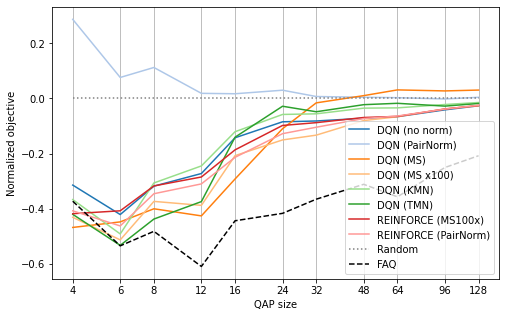

In [82]:
agents = [
    "dqn_sm2",
    "dqn_pn",
    "dqn_ms",
    "dqn_ms100x",
    "dqn_kmn",
    "dqn_tmn",
    "rf_ms100x",
    "rf_pn"
]

create_plot(agents + ["random", "faq"], size=(8,5))

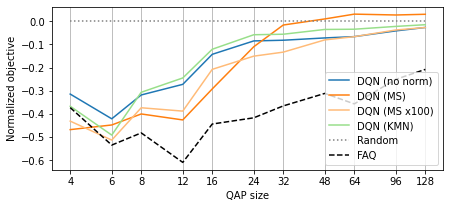

In [94]:
agents = [
    "dqn_sm2",
    "dqn_ms",
    "dqn_ms100x",
    "dqn_kmn",
]

create_plot(agents + ["random", "faq"], size=(7,3))
plt.savefig(plot_path / "dqn_norms_generalization.pdf")

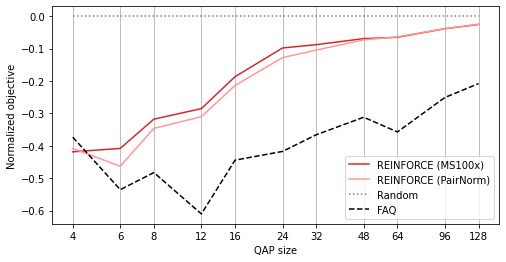

In [85]:
agents = [
    "rf_ms100x",
    "rf_pn"
]

create_plot(agents + ["random", "faq"], size=(8,4))
plt.savefig(plot_path / "rf_norms_generalization.pdf")

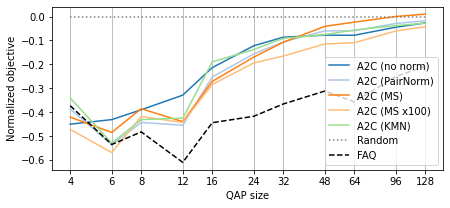

In [93]:
agents = [
    "a2c_none_2",
    "a2c_pn_2",
    "a2c_ms_2",
    "a2c_ms100x",
    "a2c_kmn",
]

create_plot(agents + ["random", "faq"], size=(7,3))
plt.savefig(plot_path / "a2c_norms_generalization.pdf")